# Chatterjee Eyigungor AER 2012

Replicates the Chatterjee and Eyigungor, American Economic Review 2012 paper.

The link to the paper is here: 

https://www.aeaweb.org/articles?id=10.1257/aer.102.6.2674

In [19]:
using Pkg; Pkg.activate(joinpath(@__DIR__, "..")); Pkg.instantiate()
using LTBonds 
using Plots
using PrettyTables 
using BenchmarkTools
using Random

default(labels = "")

  Activating environment at `~/Github/floating-rate-debt/Project.toml`


# Long bond model

In [11]:
# The following are exactly the parameters of Chatterjee and Eyigungor (2012)
# But we start with a one period bond
mLB = let
    R = 1.01
    β = 0.9540232420
    pref = Preferences(β = β, u = make_CRRA(ra = 2))
    y = discretize(YProcess(n = 200, ρ = 0.948503, std = 0.027092, μ = 0.0, span = 3.0, tails = false))
    m = MTruncatedNormal(; std = 0.003, span = 2.0)
    bond = BondCE2012(n = 350, min = 0.0, max = 1.5, κ = 0.03, λ = 0.05)
    penalty = DefCosts(pen1 = -0.1881927550, pen2 = 0.2455843389, quadratic = true, reentry = 0.0385)
    
    generate_workspace(LTBondModel(
        y = y,
        m = m, 
        preferences = pref, 
        bond = bond, 
        def_costs = penalty, 
        R = R
    ))
end;

In [12]:
@time solve!(mLB; max_iters = 1000, g = 1.0, err = 1e-10, print_every = 50)

1: (v = 1.6244790221635022, q = 0.8576495059087789, vD = 0.5716845187082242)
51: (v = 0.022457416153397247, q = 0.38782721112418195, vD = 0.004412790272482425)
101: (v = 0.006506578018765197, q = 0.07770768757025148, vD = 0.0031021468498764193)
151: (v = 0.001357882583420178, q = 0.010455539379481515, vD = 0.0007988691200111475)
201: (v = 0.0002525299809974513, q = 0.0017353407477068705, vD = 0.0001662605155985375)
251: (v = 3.763526810018902e-5, q = 0.00020787852958548125, vD = 2.7931177523754513e-5)
301: (v = 6.408747143638038e-6, q = 3.8495161196805405e-5, vD = 4.537298035955928e-6)
351: (v = 1.041132730250638e-6, q = 6.421417442004085e-6, vD = 7.265661920996536e-7)
401: (v = 1.6706425043366835e-7, q = 1.0445455048690988e-6, vD = 1.1576449310268799e-7)
451: (v = 2.690643086111777e-8, q = 1.6955101189708444e-7, vD = 1.856798803601123e-8)
501: (v = 4.344993698168764e-9, q = 2.7485994036346995e-8, vD = 2.992358361098013e-9)
551: (v = 7.026130788290175e-10, q = 4.452895718820571e-9, vD 

### Some policy plots 

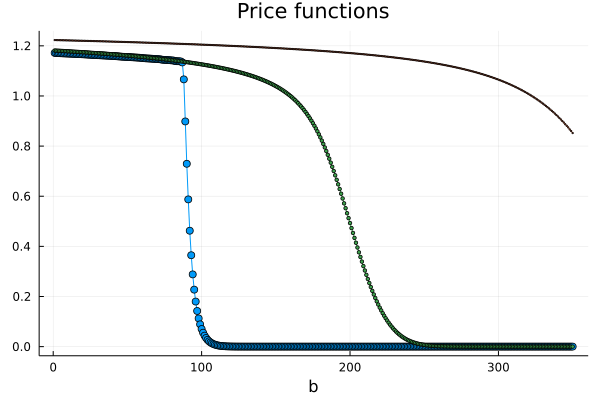

In [13]:
let a = mLB
    q = get_q(a)
    plot(q[:, 1], marker = :auto, title = "Price functions", xlabel = "b") 
    plot!(q[:, end], marker = 1) 
    plot!(q[:, 100], marker = 2) 
end

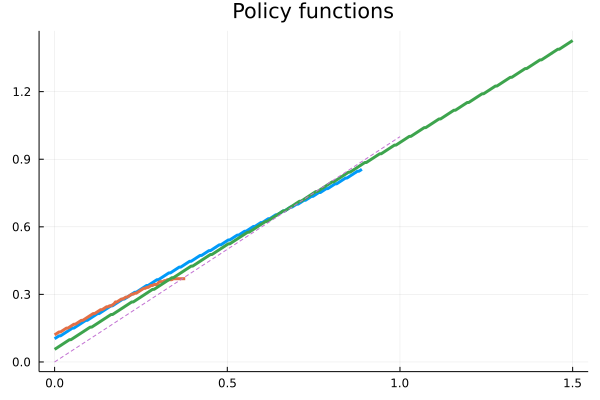

In [14]:
let yi = 100, ylow = 1, a = mLB
    yhigh = length(get_y_grid(a))
    b_pol = get_b_pol(a)
    b_grid = get_b_grid(a)
    out_low = [ 
        all_default_at(a, i, ylow) ? missing : b_grid[b_pol[i, ylow][end].idx]  
        for i in eachindex(b_grid)
    ]
    out_high = [ 
        all_default_at(a, i, yhigh) ? missing : b_grid[b_pol[i, yhigh][1].idx]  
        for i in eachindex(b_grid)
    ]
    out_mid = [ 
        all_default_at(a, i, yi) ? missing : b_grid[b_pol[i, yi][end].idx]  
        for i in eachindex(b_grid)
    ]
    plot(b_grid, out_mid, lw = 3)
    plot!(b_grid, out_low, lw = 3)
    plot!(b_grid, out_high, lw = 3)

    plot!([0, 1.0], [0, 1.0], ls = :dash)
    plot!(title = "Policy functions")
end

### Simulations and moments

In [20]:
big_T = 20_000 
big_N = 1_000
rng = Random.seed!(1234)

MersenneTwister(1234)

In [24]:
@time shocks, paths = create_shocks_paths(mLB, big_T, big_N; rng);

  2.637877 seconds (65.02 k allocations: 3.110 GiB, 20.32% gc time)


In [25]:
@time simulation!(paths, shocks, mLB; n = big_T, trim = 1000, trim_def = 20)
@time moments_LB = moments(paths, mLB);

  0.288519 seconds (7.01 k allocations: 1000.359 KiB)
  1.087770 seconds (5 allocations: 152.664 MiB)


In [26]:
pretty_table(pairs(moments_LB))

┌─────────────┬─────────────┐
│        Keys │      Values │
│      Symbol │     Float64 │
├─────────────┼─────────────┤
│   mean_bp_y │    0.699829 │
│   mean_mv_y │    0.703646 │
│ mean_spread │   0.0815247 │
│  std_spread │   0.0444556 │
│      mean_κ │        0.03 │
│       std_κ │ 2.08167e-17 │
│       max_κ │        0.03 │
│     std_c_y │     1.10639 │
│    cor_tb_y │   -0.433787 │
│     cor_r_y │   -0.647898 │
│   cor_r_b_y │  -0.0302444 │
│    cor_r_tb │    0.772762 │
│    def_rate │   0.0682493 │
│   run_share │         0.0 │
└─────────────┴─────────────┘
